# Investment thesis

Evaluation of whether the Ames Housing Market presents an attractive investment opportunity and which features to be considered when attempting real estate arbitrage.

- note: valuation

In [1]:
#imports

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, RobustScaler, PowerTransformer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Lasso, Ridge
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from xgboost import XGBRegressor

import statsmodels.stats.api as sms
import statsmodels.regression.linear_model as smf

import warnings
warnings.filterwarnings("ignore")

In [2]:
train_boxcox = pd.read_csv("datasets/train_boxcox.csv")
id_ = train_boxcox["id"]
train_eng = pd.read_csv("datasets/train_engineered.csv")
y = train_eng["saleprice"]

In [3]:
train_boxcox.drop(["Unnamed: 0", "id"], axis = 1, inplace = True)

In [4]:
def get_impt_features(models, x, y):
    
    '''gets feature importances/ coefficients of models and predicted values
    returns them into 2 dataframes'''
    
    x_train, x_val, y_train, y_val = train_test_split(x, np.log(y), random_state = 42, shuffle = False)
    
    rs = RobustScaler()
    x_train_rs = rs.fit_transform(x_train)
    x_val_rs = rs.transform(x_val)
    
    results = pd.DataFrame()
    
    for name, model in models.items():
        model.fit(x_train_rs, y_train)
        
        try:
            importances = np.exp(model.coef_)
            df_features = (
                        pd.DataFrame(
                            zip(x_train.columns, importances),
                            columns=[name, f"{name} Importance"],
                      )
                        .sort_values(f"{name} Importance", ascending=False)
                        .reset_index(drop=True)
                    )
            results = pd.concat([results, df_features], axis=1)

        except:
            pass
        
        try:
            importances = np.exp(model.feature_importances_)
            df_features = (
                        pd.DataFrame(
                            zip(x_train.columns, importances),
                            columns=[name, f"{name} Importance"],
                      )
                        .sort_values(f"{name} Importance", ascending=False)
                        .reset_index(drop=True)
                    )
            results = pd.concat([results, df_features], axis=1)

        except:
            pass
        
        
    for name, model in models.items():
        if name == "XGBR":
            y_train_pred = model.predict(x_train_rs)
            y_val_pred = model.predict(x_val_rs)
    
            x["saleprice_predicted"] = np.exp(np.hstack((y_train_pred, y_val_pred)))
            x["saleprice"] = y
    
    #must you inverse transform before predicting?
    
    return results, x

In [5]:
ridge_best = Ridge(alpha= 3.5, max_iter= 10000000.0, random_state= 42)
lasso_best = Lasso(alpha= 0.0002, max_iter= 10000000.0, random_state= 42)
xgbr = XGBRegressor(gamma = 0.0, learning_rate = 0.1, max_depth = None, random_state = 42, reg_alpha = 1e-06)
importances, dataset = get_impt_features({"Ridge": ridge_best, "Lasso": lasso_best, "XGBR": xgbr}, train_boxcox, y)

In [6]:
def barplotter(df, x_name, y_name, n):
    
    '''takes in input dataframe, name of x column, name of y column, and number of rows.
    returns barchart.'''

    bar = sns.catplot(x = x_name,
                          y = y_name,
                          data = df.head(n),
                          kind = 'bar',
                          height = 8,
                          aspect = 2,
                          palette = "icefire"
                     )

    plt.title('Coefficients', fontsize = 24)
    plt.xlabel("Coefficients", size = 20)
    plt.ylabel("Features", size = 20)
    plt.show()
       

# Valuation

## Feature Importances

The feature importances ranking from the XGBRegressor model made the most sense - these are the predictors commonly thought to predict sales price, according to real estate experts and even common wisdom. This will be the model selected for valuation.

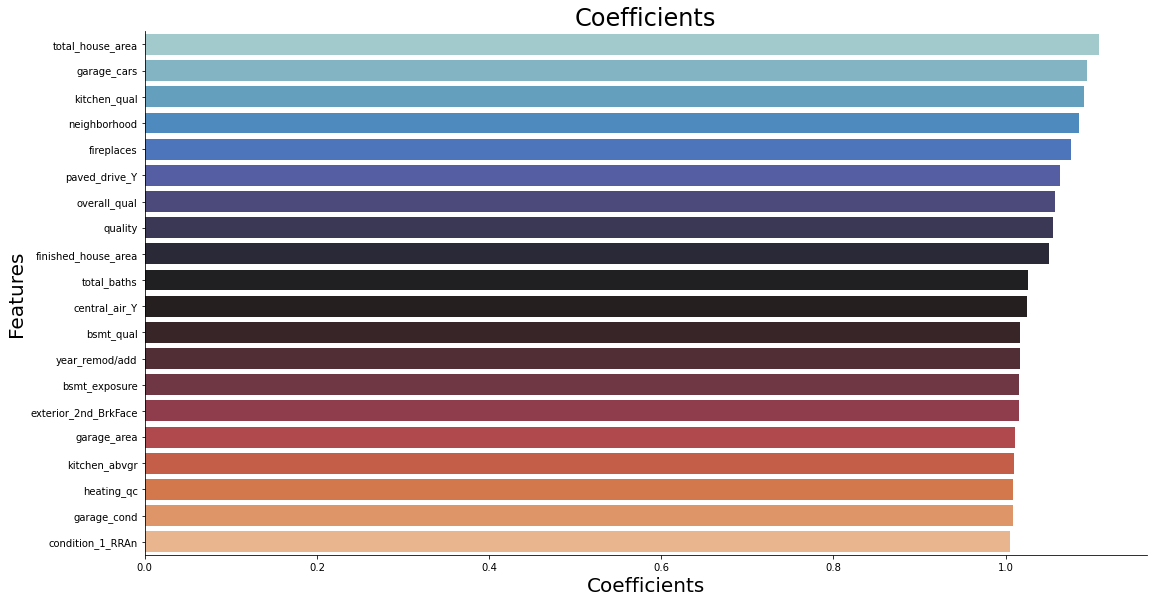

In [7]:
barplotter(importances, "XGBR Importance", "XGBR", 20)

## Automated Valuation

In [8]:
def predictor(x, y, values):
    x_train, x_val, y_train, y_val = train_test_split(x, np.log(y), random_state = 42, shuffle = False)
    
    rs = RobustScaler()
    x_train_rs = rs.fit_transform(x_train)
    x_val_rs = rs.transform(x_val)
    
    #boxcox, robust transform and log sale price
    
    xgbr = XGBRegressor(gamma = 0.0, learning_rate = 0.1, max_depth = None, random_state = 42, reg_alpha = 1e-06)
    
    #inverse transform first or exponentiate first?
    
    xgbr.fit(x_train_rs, y_train)
    
    if len(values) == 1:
        price = xgbr.predict(values)
        return price
        
    else:
        prices = []
        
        for value in values:
            price = xgbr.predict(value)
            prices.append(price)
    
    return prices    

### Neighborhoods

In [ ]:
def preprocessing(df):
    
    '''merges the neighborhood name columns for analysis. recall that neighborhood has been clustered'''
    
    df["id"] = id_
    
    train_cleaned = pd.read_csv("datasets/train_cleaned.csv")
    train_cleaned.drop([328, 616, 960, 1147, 1885, 858, 761], axis = 0, inplace = True)
    nbs = train_cleaned.filter(["id", "neighborhood"])
    
    df = df.merge(nbs, on = "id", how = "right")
    
    for col in ["Unnamed: 0", "Unnamed: 0.1", "id"]:
        try:
            df.drop(columns = col, axis = 1, inplace = True)
        except KeyError:
            pass
   
    df.rename(columns = {"neighborhood_x": "nb_cluster", "neighborhood_y": "nb_name"}, inplace = True)
    df = df.reindex(sorted(df.columns), axis=1)
    
    impt = importances.head(20)
    impt = impt["XGBR"].values
    
    cols = set(impt) - set("neighborhood")
    cols.update({"nb_cluster", "nb_name", "finished_house_area"})
    
    df = df.filter(cols)
    df["saleprice"] = y
    
    return df